# Kepler
*Anaelle JAFFRÉ, Guénaël ROGER*

This Jupyter Notebook is a report refering to an experimental project. It aims to discover an application of Echo State Networks (ESN) throughout a dataset of Kepler labelled time series data.

Faudrait peut-être écrire en français ? On écrit en français ou en anglais ?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

from sklearn.metrics import accuracy_score, roc_auc_score


## Dataset
Là on décrit le dataset parce qu'il est vachement bien quand-même, j'ai pas raison ? J'ai toujours raison

In [2]:
DATA_PATH = Path("../data")

train_df = pd.read_csv(DATA_PATH / "exoTrain.csv")
test_df  = pd.read_csv(DATA_PATH / "exoTest.csv")

On analyse rapidement le dataset.

In [3]:
train_df.shape, test_df.shape # type: ignore

train_df.head()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


Y'a beaucoup de données, enfin pour moi 5000 c'est beaucoup. Je sais pas si c'est vraiment beaucoup.

Après que dire des float... ?

### Séparation X/y

Par convention, en colonne 0 on a les labels, et le reste c'est les séries temporelles.

In [4]:
y_train = train_df.iloc[:, 0].values
X_train = train_df.iloc[:, 1:].values

y_test = test_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values

#### Déséquilibre des classes

In [5]:
pd.Series(y_train).value_counts(normalize=True)

1    0.992727
2    0.007273
Name: proportion, dtype: float64

Stats globales

In [6]:
X_train.mean(), X_train.std()

(np.float64(130.41674038757165), np.float64(22072.212527378146))

##### Visualisation

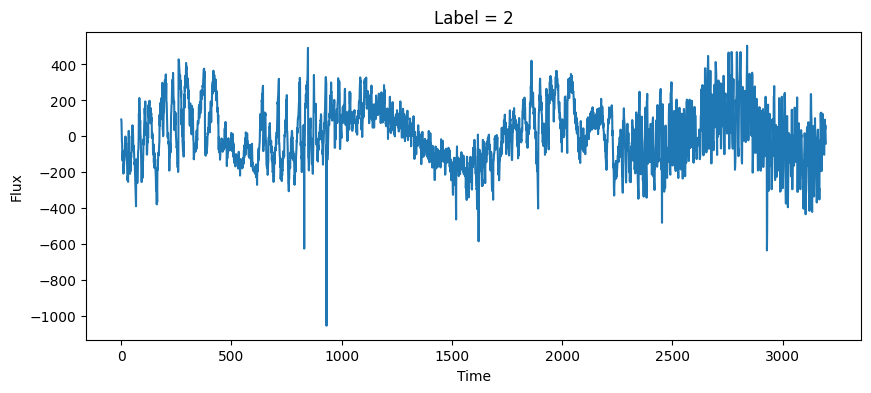

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(X_train[0])
plt.title(f"Label = {y_train[0]}")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

#### Mise en forme pour l'ESN

##### Bases

In [ ]:
X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

# Sequences
X_train_seq = [x for x in X_train]
X_test_seq  = [x for x in X_test]

# Verify the shape of X: must be (n, 1)
print(X_train_seq[0].shape)

# Reshape y
y_train_seq = [
    np.full((x.shape[0], 1), y)
    for x, y in zip(X_train_seq, y_train)
]

y_test_seq = [
    np.full((x.shape[0], 1), y)
    for x, y in zip(X_test_seq, y_test)
]

# Verify the shape of y: must be (n, 1)
print(y_train_seq[0].shape)

# Float labels
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Normalisation
mean = np.mean(X_train)
std  = np.std(X_train)

X_train_seq = [(x - mean) / std for x in X_train_seq]
X_test_seq  = [(x - mean) / std for x in X_test_seq]

(3197, 1)
(3197, 1)


##### Paramètres de l'ESN

In [9]:
units = 500
leak_rate = 0.3
input_scaling = 0.5
spectral_radius = 0.9
ridge = 1e-6

### ESN

In [10]:
reservoir = Reservoir(
    units=units,
    lr=leak_rate,
    input_scaling=input_scaling,
    sr=spectral_radius
)

readout = Ridge(ridge=ridge)

esn = reservoir >> readout

#### Entraînement

In [ ]:
# Entrainement
esn.fit(X_train_seq, y_train_seq)

# Prediction
y_pred_seq = esn.run(X_test_seq) # Returns one sequence per entry

y_pred = np.array([yp.mean() for yp in y_pred_seq]) # One decision per serie, not per entry
y_pred_label = (y_pred > 0.5).astype(int)

# Evaluation
accuracy = accuracy_score(y_test_seq, y_pred_label)
auc = roc_auc_score(y_test_seq, y_pred)

accuracy, auc